### Problem Description

- This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012.


- what we want here is to make a model which classify every review and print an output saying that it's a positive review or negative review and we will use streamlit framework which is useful to create and share web data apps


- dataset link: https://www.kaggle.com/snap/amazon-fine-food-reviews?select=Reviews.csv

### Import Packages

In [79]:
# Add environment Packages paths to conda
import os, sys
# env_name = "food_review"
# sys.path.append(f"C:\\Environments\\{env_name}\\lib\\site-packages\\")

import pandas as pd
import numpy as np

# Text preprocessing packages
import nltk # Text libarary
# nltk.download('stopwords')
import string # Removing special characters {#, @, ...}
import re # Regex Package

# Corpora is a group presenting multiple collections of text documents. A single collection is called corpus.
from nltk.corpus import stopwords # Stopwords

from nltk.stem import SnowballStemmer, WordNetLemmatizer # Stemmer & Lemmatizer
#from gensim.utils import simple_preprocess  # Text ==> List of Tokens

# Text Embedding
from sklearn.feature_extraction.text import TfidfVectorizer

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Saving Model
import pickle

# Visualization Packages
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.3)
%matplotlib inline

### Read Dataset

In [80]:
%%time
df = pd.read_csv('The_Reviews.csv')

Wall time: 3.13 s


In [81]:
f"{df.shape[0]:,} Review"

'568,454 Review'

In [82]:
cols = ['Text', 'Score']
df_text = df[cols].copy()
df_text.head()

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5


### Drop Duplicates
Save the Cleaned data-frame also with the variable `df_text`

In [83]:
df_text.duplicated().sum()

174779

In [84]:
df_text.drop_duplicates(inplace=True)
df_text.reset_index(drop=True,inplace=True)

In [85]:
df_text.duplicated().sum()


0

### Target Variable Pre-Processing
`target` will be 
 - 0 if score < 3 
 - 1 otherwise

In [86]:
df_text['target'] = [0 if i <3  else 1 for i in df_text.Score ]

#### Plot Countplot for target Variable

D:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='target', ylabel='count'>

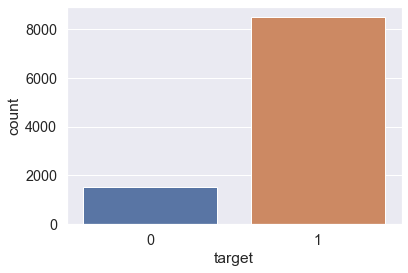

In [87]:
sns.countplot(df_text['target'][:10000])

Notice how such variance is huge ...   
Then we need to down-sample such data ... by which both the positive and negative classes are balanced.

### Balance Data Target

In [88]:
# Sample from positive reviews Same number of negative reviews

#NEG_N it will store the size of negative reviews or zeros on the data frame
NEG_N = df_text.target.value_counts()[0]
#so, df_pos contains the positive reviews text or text with value equals to 1 in target
df_pos = df_text[df_text['target'] == 1]['Text'].sample(NEG_N, replace=False)
#now we will make a new dataframe where the size of positive reviews is same as the size of negative reviews
df_text_balanced = pd.concat([df_text.iloc[df_pos.index], df_text[df_text.target == 0]])
df_text_balanced.reset_index(drop=True,inplace=True)

D:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(0.0, 1500.0)

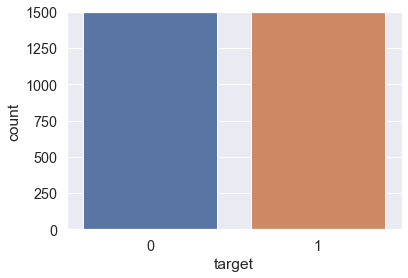

In [89]:
sns.countplot(df_text_balanced['target'])
plt.ylim(0,1500)

### Text Pre-Processing

In [90]:
stop_words = list(stopwords.words('english'))
stemmer = SnowballStemmer("english")
lemmatizer= WordNetLemmatizer()

In [91]:
#Removing every not from stop words
stop_words.remove('not')
for i in stop_words:
    if "n't" or "n'" in i:
        stop_words.remove(i)



In [92]:
def cleaning_text(Text):
    #Removing Stop Words
    Text=[i for i in str(Text).split() if i not in stop_words]
    
    #Removing special characters
    Text=[re.sub('[^A-Za-z0-9]+', '', str(i)) for i in Text]


    #lemmatizing each word
    Text=[lemmatizer.lemmatize(y) for y in Text]
    #print(Text)

    #stemming each word
    Text=[stemmer.stem(y) for y in Text]
    
    str1 = " " 
    Cleaned_Text=str1.join(Text)
    #Remove numbers
    Cleaned_Text=''.join([i for i in Cleaned_Text if not i.isdigit()])
    # return string  
    return (Cleaned_Text)
    
    
df_text_balanced.Text=df_text_balanced.Text.apply(lambda text : cleaning_text(text))


### Split Test & Training Data

In [93]:
X = df_text_balanced.iloc[:, 0].values
y = df_text_balanced.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Text Embedding
 - Use `TfidfVectorizer`
 - `fit` on the training data only
 - `transform` on training and test 

In [95]:

## TFIDF embedding for the Description
vectorizer = TfidfVectorizer() ## Write your code here
# fit on training (such vectorizer will be saved for deployment)
vectorizer.fit(X_train)
# transform on training data
X_train = vectorizer.fit_transform(X_train)
# transform on testing data
X_test = vectorizer.transform(X_test)



In [96]:
# See the dimensions of your data embeddings before entering to the model
X_train.shape,X_test.shape

((79917, 69578), (34251, 69578))

### Modelling

In [97]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

##### Sklearn framework steps
 - init
 - fit
 - predict

In [98]:
## initialize your Model
clf = LogisticRegression(solver='liblinear')

# Fit your Model on the Training Dataset
clf.fit(X_train, y_train)

# Predict on Test data
preds =  clf.predict(X_test)

# Calculate Model Accuracy
acc = accuracy_score(preds, y_test)
print(f"Model Accuracy = {round(acc*100,2)}%")

Model Accuracy = 86.55%


In [99]:
#we will make a confusion matrix
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
tn, fp, fn, tp

(14859, 2214, 2392, 14786)

### Raw Instance Prediction

In [100]:
def raw_test(review, model, vectorizer):
    # Clean Review
    review_c = cleaning_text(review)
    # Embed review using tf-idf vectorizer
    embedding = vectorizer.transform([review_c])
    # Predict using your model
    prediction = model.predict(embedding)
    # Return the Sentiment Prediction
    return "Positive" if prediction == 1 else "Negative"

In [101]:
review_1 = "That's a good Dish, Good Job"
review_2 = "That's the worst Dish ever tasted"

In [102]:
raw_test(review_1, clf, vectorizer)

'Positive'

In [103]:
raw_test(review_2, clf, vectorizer)

'Negative'

### Saving Models for Deployment

In [104]:
import pickle

In [105]:
model_name = 'rf_model.pk'
vectorizer_name = 'tfidf_vectorizer.pk'
model_path = os.path.join('/', model_name)
vect_path = os.path.join('/', vectorizer_name)

pickle.dump(clf, open(model_name, 'wb'))
pickle.dump(vectorizer, open(vectorizer_name, 'wb'))


### Load model Again and test them

In [106]:
loaded_model = pickle.load(open(model_name, 'rb'))
loaded_vect = pickle.load(open(vectorizer_name, 'rb'))

In [107]:
raw_test(review_1, loaded_model, loaded_vect)

'Positive'

In [108]:
raw_test(review_2, loaded_model, loaded_vect)

'Negative'

### Now, I will Deploy The ML model using Streamlit Framework